# Vehicle Image Classification

In this notebook We are going to create a CNN Model which can take a vehicle image and predict its Make/Model combination. The image set is limited one of 1500 for training and 1000 for validation. If we can get more images, then it can be easily be extended to predict the model year as well.  

The CNN Model is based on VGG 16 model(http://www.robots.ox.ac.uk/~vgg/research/very_deep/), which is the ImageNet competition winner for year 2013. The VGG model has been pretrained to identify 1000 different categories of images and we are going to reuse that, and chop the last layer, and add our new dense layers, to classify images to one of the 18 different vehicle models, we have.  

The Economist says that data is the new oil in the 21st Century. If data is the crude oil, databases and data warehouses are the drilling rigs that digs and pumps the data on the internet, then think of deep learning as the oil refinery that finally turns crude oil into all the useful and insightful final products.

Activation functions cannot be linear because neural networks with a linear activation function are effective only one layer deep, regardless of how complex their architecture are. Input to networks are usually linear transformation (input * weight), but real world and problems are non-linear. 

To make the incoming data nonlinear, we use nonlinear mapping called activation function. An activation function is a decision making function that determines the presence of particular neural feature. It is mapped between 0 and 1, where zero mean the feature is not there, while one means the feature is present. 

The coding is implemented with Keras and Theano. The coding is done with Python 3 and Keras 2. Keras is a deep learning library that provides nicer, easier-to-use abstractions on top of Theano/TensorFlow, including pretty awesome training tools, and a class_weights option.

utils.py - Contains various utility functions, for the training. It is based out of the fast.ai course from Jeremy Howard.

Here we use concept of Transfer Learning - When you look at what these Deep Learning networks learn, they try to detect edges in the earlier layers, Shapes in the middle layer and some high level data specific features in the later layers. VGG16 has already been trained to do this. Training a model from scratch and achieving decent accuracy could take lot of time. Transfer learning, is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. Since this task is also related to image classification, we wanted to start with VGG16 model.

Why Transfer Learning?
1) In practice a very few people train a Convolution network from scratch (random initialisation) because it is rare to get enough dataset. So, using pre-trained network weights as initialisations or a fixed feature extractor helps in solving most of the problems in hand.
2) Very Deep Networks are expensive to train. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.
3) Determining the topology/flavour/training method/hyper parameters for deep learning is a black art with not much theory to guide you.

As such, retraining (also called “transfer learning”) aims to take a full-trained neural net, and retrain it to perform better on the specific problem you’d like to handle. This usually involves some degree of “forgetting”, either by excising entire layers from the stack, or by slowly erasing the network’s ability to distinguish a type of object  in favor of better accuracy at recognizing the one you care about.

The big advantage of transfer learning are you will get better results much faster, and with less data than if you train from scratch. A full training might take months on multiple GPUs and require millions of images, while retraining can conceivably be done in hours on a laptop with a couple thousand images.

Theano vs tensorflow : (image data format varies. 

theano : # of samples, # of rows, # of cols, # of channels (3 for RGB, 1 for gray scale etc)
tensor : # of samples, # of channels, # of rows, # of cols

Specified in the keras.json
{
    "epsilon": 1e-07,
    "backend": "theano",
    "floatx": "float32",
    "image_dim_ordering": "th",
    "image_data_format": "channels_first"
}

So if using theano, roll the axis from 3 to 1, to get image data in same format as theano.
image_data = np.rollaxis(image_data, 3, 1)

In CNN, # of outputs will equal # of classes, 18 in our case. One hot encoding helps it. to_categorical function in utils does that for us. 

In [4]:
#####![title](/img/WhatLayersDo.png)

In [57]:
%%html
<img src="img/WhatLayersDo.png",width=60,height=60>

In [ ]:
Lets take a brief look at what are the different VGG architectures are.

In [58]:
%%html
<img src="img/VGG16Architecture.png",width=60,height=60>

The VGG networks from Oxford were the first to use much smaller 3×3 filters in each convolutional layers and also 
combined them as a sequence of convolutions. This seems to be contrary to the principles of LeNet, where large 
convolutions were used to capture similar features in an image. Instead of the 9×9 or 11×11 filters of AlexNet, 
filters started to become smaller, too dangerously close to the infamous 1×1 convolutions that LeNet wanted to avoid, 
at least on the first layers of the network. But the great advantage of VGG was the insight that multiple 3×3 
convolution in sequence can emulate the effect of larger receptive fields, for examples 5×5 and 7×7. These ideas will 
be also used in more recent network architectures as Inception and ResNet.

The VGG networks uses multiple 3x3 convolutional layers to represent complex features. Notice blocks 3, 4, 5 of VGG-E: 
256×256 and 512×512 3×3 filters are used multiple times in sequence to extract more complex features and the 
combination of such features. This is effectively like having large 512×512 classifiers with 3 layers, which are 
convolutional! This obviously amounts to a massive number of parameters, and also learning power. But training of 
these network was difficult, and had to be split into smaller networks with layers added one by one. All this because 
of the lack of strong ways to regularize the model, or to somehow restrict the massive search space promoted by the 
large amount of parameters.

VGG used large feature sizes in many layers and thus inference was quite costly at run-time. Reducing the number of 
features, as done in Inception bottlenecks, will save some of the computational cost.

In [ ]:
Lets see how it extracts useful information in different layers

In [59]:
%%html
<img src="img/Visualization1.png",width=60,height=60>

In [60]:
%%html
<img src="img/Visualization2.png",width=60,height=60>

In [3]:
from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *

Using Theano backend.


## Setup dirs

The directory structure with the images, has 2 folders - Sample, test - under main folder data/cars, on the current folder path. Under Sample, we have folders train, valid, for training and validation, and each of them have 18 folders for each of the vehicle classification we have.

In [4]:
path = "data/cars/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
#batch_size=64
batch_size=16

In [21]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.
Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.
Found 118 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [64]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

## Basic VGG

We start with our  VGG approach.  We will be using VGG with batch normalization, the details can be found in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb). 

### Initial model

First we create a simple fine-tuned VGG model to be our starting point. The VGG model file is present in http://files.fast.ai/models/vgg16_bn.h5

In [65]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(18)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [66]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.


In [67]:
test = get_data(path+'test')

Found 118 images belonging to 1 classes.


In [68]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [69]:
save_array(path+'results/test.dat', test)

In [70]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [71]:
test = load_array(path+'results/test.dat')

In [72]:
gen = image.ImageDataGenerator()

In [75]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
##Did training with 3 epochs first and then did again with 5 epochs, to improve accuracy.

In [76]:
model.fit(trn, trn_labels, batch_size=batch_size, epochs=5, validation_data=(val, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/5
1533/1533 [==============================] - 923s - loss: 3.4951 - acc: 0.4188 - val_loss: 3.4682 - val_acc: 0.4746

In [77]:
model.save_weights(path+'results/ft1.h5')

In [ ]:
### Data augmentation
Since the data set is small, we want to do some data augmentation, to increase the training data set. This also makes 
sure that we have variety in training data set in many aspects like angles, zoom and stability while clicking the 
picture. keras image preprocessing has libraries needed for the same - ImageDataGenerator. 

In [78]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
gen_batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 1533 images belonging to 18 classes.


In [79]:
model.optimizer.lr = 1e-3

In [80]:
steps_per_epoch = int(np.ceil(batches.samples/batch_size))
validation_steps = int(np.ceil(val_batches.samples/(batch_size*2)))

In [82]:
model.fit_generator(gen_batches, steps_per_epoch, epochs=10, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/10
96/96 [==============================] - 670s - loss: 3.8888 - acc: 0.4650 - val_loss: 4.1839 - val_acc: 0.4727

In [83]:
model.save_weights(path+'results/ft2.h5')

In [84]:
model.evaluate(model.predict(val), val_labels)

ValueError: Error when checking input: expected lambda_4_input to have 4 dimensions, but got array with shape (1064, 18)

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. Since we've pre-computed the output of the last convolutional layer, we need to create a network that takes that as input, and predicts our 18 classes. Let's try using a simplified version of VGG's dense layers.

In [85]:
model.load_weights(path+'results/ft1.h5')

In [86]:
conv_layers,fc_layers = split_at(model, Conv2D)

In [87]:
conv_model = Sequential(conv_layers)

In [88]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_40 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [89]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [90]:
conv_test_feat = conv_model.predict(test)

In [91]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [92]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [93]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [94]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [95]:
conv_val_feat.shape

(1064, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 4-layer FC net, with dropout.

In [96]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/4),
        Dense(18, activation='softmax')
    ]

In [97]:
p=0.6

In [98]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/3
1533/1533 [==============================] - 18s - loss: 3.3059 - acc: 0.1507 - val_loss: 3.9752 - val_acc: 0.2218

In [100]:
bn_model.optimizer.lr = 1e-4

In [101]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/7
1533/1533 [==============================] - 13s - loss: 0.8824 - acc: 0.7182 - val_loss: 1.8271 - val_acc: 0.5686

In [102]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=5, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/5
1533/1533 [==============================] - 13s - loss: 0.1448 - acc: 0.9530 - val_loss: 2.1792 - val_acc: 0.5799

In [103]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [104]:
bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_23 (MaxPooling (None, 512, 7, 7)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512, 7, 7)         2048      
_________________________________________________________________
dropout_16 (Dropout)         (None, 512, 7, 7)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               12845568  
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
__________

In [105]:
bn_model.evaluate(conv_val_feat, val_labels)

1056/1064 [============================>.] - ETA: 0s

[2.036120785358257, 0.59304511278195493]

### Train model-Second Trial

We can now create our second baseline model - a simple 3-layer FC net instead of a 4 layer tried earlier, with dropout, to compare the effect of an extra Dense layer.

In [106]:
def get_bn_layers_2(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(18, activation='softmax')
    ]

In [107]:
p2=0.6

In [108]:
bn_model_2 = Sequential(get_bn_layers_2(p2))
bn_model_2.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
bn_model_2.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/3
1533/1533 [==============================] - 13s - loss: 3.2289 - acc: 0.1820 - val_loss: 3.1165 - val_acc: 0.3299

In [110]:
bn_model_2.optimizer.lr = 1e-4

In [111]:
bn_model_2.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=7, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/7
1533/1533 [==============================] - 13s - loss: 0.4999 - acc: 0.8461 - val_loss: 1.4804 - val_acc: 0.5959

In [112]:
bn_model_2.fit(conv_feat, trn_labels, batch_size=batch_size, epochs=5, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/5
1533/1533 [==============================] - 13s - loss: 0.0747 - acc: 0.9785 - val_loss: 1.8012 - val_acc: 0.6118

In [113]:
bn_model_2.save_weights(path+'models/conv_512_7.h5')

In [114]:
bn_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_24 (MaxPooling (None, 512, 7, 7)         0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 512, 7, 7)         2048      
_________________________________________________________________
dropout_20 (Dropout)         (None, 512, 7, 7)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               12845568  
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
__________

In [115]:
bn_model_2.evaluate(conv_val_feat, val_labels)

1056/1064 [============================>.] - ETA: 0s

[2.0611169979088286, 0.59398496240601506]

The extra dense layer, probably did not make much difference.

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [7]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.


The image shows that things are much clearer at this size.

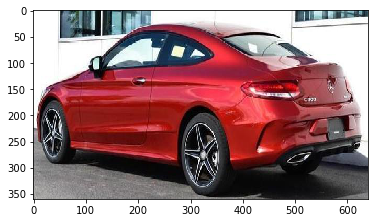

In [123]:
plot(trn[0])

In [8]:
test = get_data(path+'test', (360,640))

Found 118 images belonging to 1 classes.


In [119]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [120]:
save_array(path+'results/test_640.dat', test)

In [9]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [10]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

We can now pre-compute the output of the convolutional part of VGG.

In [11]:
conv_val_feat = vgg640.predict(val, batch_size=batch_size, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=batch_size, verbose=1)

 624/1064 [================>.............] - ETA: 486s 

KeyboardInterrupt: 

In [126]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [127]:
conv_test_feat = vgg640.predict(test, batch_size=batch_size, verbose=1)

118/118 [==============================] - 141s     


In [128]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [12]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')

In [13]:
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem.

In [14]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [15]:
nf=128; p=0.

In [16]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Conv2D(18,(3,3), padding='same'),
        Dropout(p),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [17]:
lrg_model = Sequential(get_lrg_layers())

In [18]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 22, 40)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 11, 20)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 11, 20)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 11, 20)       512       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 5, 10)        0         
__________

In [19]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/2
1533/1533 [==============================] - 122s - loss: 2.3342 - acc: 0.2642 - val_loss: 3.5520 - val_acc: 0.3036

In [138]:
lrg_model.optimizer.lr=1e-5

In [139]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/6
1533/1533 [==============================] - 119s - loss: 0.4514 - acc: 0.8754 - val_loss: 1.9582 - val_acc: 0.5498

In [140]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [141]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=5, 
             validation_data=(conv_val_feat, val_labels))## Running it again, to see if accuracy improves.

Train on 1533 samples, validate on 1064 samples
Epoch 1/5
1533/1533 [==============================] - 124s - loss: 0.0052 - acc: 0.9993 - val_loss: 1.2547 - val_acc: 0.6861

In [142]:
lrg_model.save_weights(path+'models/lrg_nmp_2.h5')

In [23]:
lrg_model.load_weights(path+'models/lrg_nmp_2.h5')

In [24]:
lrg_model.evaluate(conv_val_feat, val_labels)

1064/1064 [==============================] - 21s     

[1.2554116536464011, 0.68703007518796988]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [25]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [26]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [27]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 0.22,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.77,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ], dtype=float32)

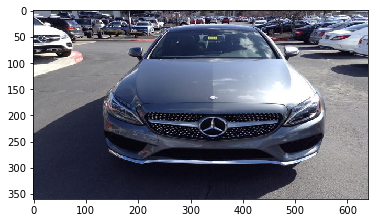

In [28]:
plt.imshow(to_plot(val[0]))

In [31]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

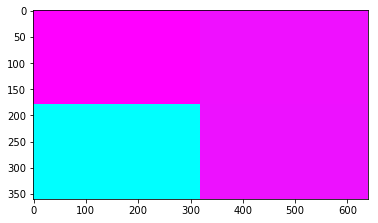

In [32]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [38]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(18,(3,3), padding='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [39]:
lrg_model = Sequential(get_lrg_layers())

In [40]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 512, 22, 40)       2048      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 22, 40)       589952    
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 22, 40)       512       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 22, 40)       147584    
_________________________________________________________________
batch_normalization_13 (Batc (None, 128, 22, 40)       512       
__________

In [41]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/2
1533/1533 [==============================] - 170s - loss: 2.0228 - acc: 0.3712 - val_loss: 2.9339 - val_acc: 0.3355

In [43]:
lrg_model.optimizer.lr=1e-5

In [44]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, epochs=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 1533 samples, validate on 1064 samples
Epoch 1/6
1533/1533 [==============================] - 172s - loss: 0.5107 - acc: 0.8389 - val_loss: 1.5499 - val_acc: 0.6382

In [45]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [46]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap 

In [47]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [48]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [49]:
inp = np.expand_dims(conv_val_feat[0], 0)

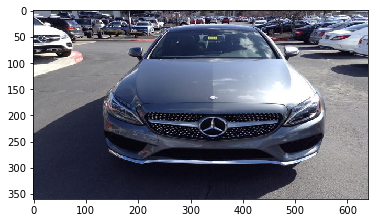

In [50]:
plt.imshow(to_plot(val[0]))

In [51]:
cm = get_cm2(inp, 0)

In [52]:
cm = get_cm2(inp, 4)

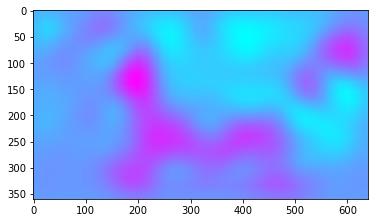

In [53]:
plt.imshow(cm, cmap="cool")

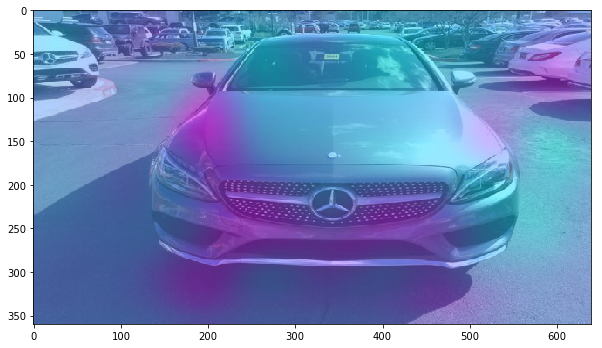

In [54]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Training a model from scratch - Four conv/pooling pairs + dropout - Re-doing above steps again

In [93]:
batch_size=64
### It will be good to shuffle the data. get_batches method, by default, assumes shuffle is true, unless specified.
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
steps_per_epoch = int(np.ceil(batches.samples/batch_size))
validation_steps = int(np.ceil(val_batches.samples/(batch_size*2)))

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.
Found 1533 images belonging to 18 classes.
Found 1064 images belonging to 18 classes.
Found 118 images belonging to 1 classes.


In [ ]:
###Creating a new model with 3 conv + pooling pairs, and 3 dense layers

In [94]:
new_model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Conv2D(64,(3,3), activation='relu'), # conv2D(#of filters, rows, columns), can specify border_mode, 
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(128,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),## Can specify pool_size=(2,2) etc. which means it will take area of 2*2 and get the max value
        Conv2D(256,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(512,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(512,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Flatten(), ## flattens to create the feature vector
        Dense(200, activation='relu'),## Dense layers act as the classifier portion of the CNN
        BatchNormalization(),
        Dropout(0.5),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(18, activation='softmax') ## softmac activation function gives probablity of all 18 classes.
    ])

In [95]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [96]:
test = load_array(path+'results/test.dat')

In [97]:
new_model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [98]:
new_model.fit_generator(batches, steps_per_epoch, epochs=2, validation_data=val_batches, 
                 validation_steps=validation_steps) ## validation_split=0.2, in case we want to use a single folder 
#of images

Epoch 1/2
24/24 [==============================] - 1284s - loss: 4.1116 - acc: 0.0698 - val_loss: 2.9203 - val_acc: 0.0667

In [99]:
new_model.save_weights(path+'models/new_model_try_1.h5')

In [100]:
new_model.load_weights(path+'models/new_model_try_1.h5')

In [101]:
new_model.optimizer.lr=0.001

In [104]:
hist=new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps) ## validation_split=0.2, in case we want to use a single folder 
#of images

Epoch 1/3
24/24 [==============================] - 1388s - loss: 2.6045 - acc: 0.2635 - val_loss: 4.9570 - val_acc: 0.0385

KeyboardInterrupt: 

In [103]:
new_model.optimizer.lr=0.00001

In [104]:
hist=new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps) ## validation_split=0.2, in case we want to use a single folder 
#of images

Epoch 1/3
24/24 [==============================] - 1388s - loss: 2.6045 - acc: 0.2635 - val_loss: 4.9570 - val_acc: 0.0385

KeyboardInterrupt: 

In [105]:
new_model.optimizer.lr=0.005

In [106]:
hist=new_model.fit_generator(batches, steps_per_epoch, epochs=2, validation_data=val_batches, 
                 validation_steps=validation_steps) ## validation_split=0.2, in case we want to use a single folder 
#of images

Epoch 1/2
24/24 [==============================] - 1608s - loss: 2.1334 - acc: 0.3512 - val_loss: 5.9337 - val_acc: 0.0470

In [107]:
new_model.optimizer.lr=0.0005

In [108]:
hist=new_model.fit_generator(batches, steps_per_epoch, epochs=10, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/10
24/24 [==============================] - 1605s - loss: 1.9073 - acc: 0.4170 - val_loss: 6.3708 - val_acc: 0.0461

In [109]:
new_model.save_weights(path+'models/new_model_try_1.h5')

In [110]:
new_model.load_weights(path+'models/new_model_try_1.h5')

In [111]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_33 (Batc (None, 3, 224, 224)       12        
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 222, 222)      1792      
_________________________________________________________________
batch_normalization_34 (Batc (None, 64, 222, 222)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 111, 111)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 109, 109)     73856     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 109, 109)     512       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 128, 54, 54)       0         
__________

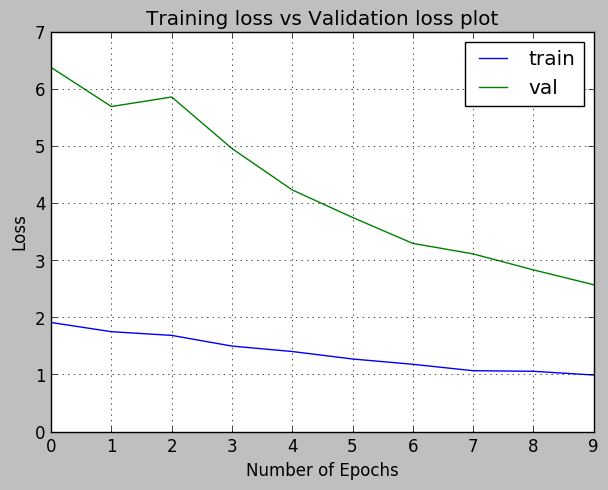

In [112]:
###plots training loss vs validation loss

xc=range(10) ## number of epochs
plt.figure(1, figsize=(7,5))
plt.plot(xc, hist.history["loss"])
plt.plot(xc, hist.history["val_loss"])

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.title("Training loss vs Validation loss plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

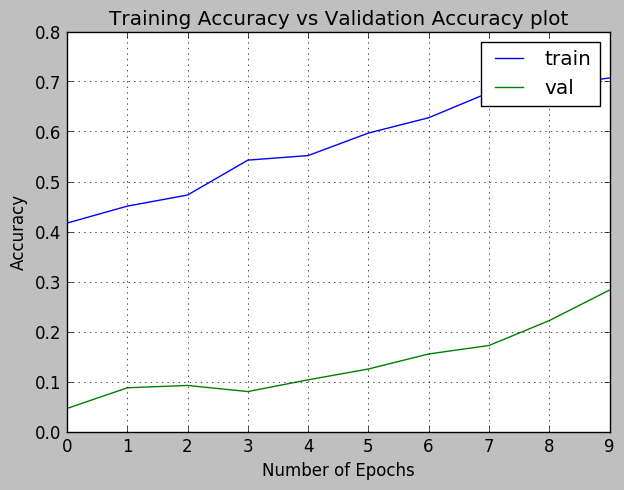

In [113]:
###plots training Accuracy vs validation Accuracy

xc=range(10) ## number of epochs
plt.figure(2, figsize=(7,5))
plt.plot(xc, hist.history["acc"])
plt.plot(xc, hist.history["val_acc"])

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.title("Training Accuracy vs Validation Accuracy plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

In [71]:
new_model.optimizer.lr=0.0005 ## Keeping same learning rate, running another 10 epochs, to see if val acc is improving

In [114]:
hist=new_model.fit_generator(batches, steps_per_epoch, epochs=10, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/10
24/24 [==============================] - 1416s - loss: 0.8048 - acc: 0.7717 - val_loss: 2.3949 - val_acc: 0.3534

In [115]:
new_model.save_weights(path+'models/new_model_try_1_1.h5')

In [116]:
new_model.load_weights(path+'models/new_model_try_1_1.h5')

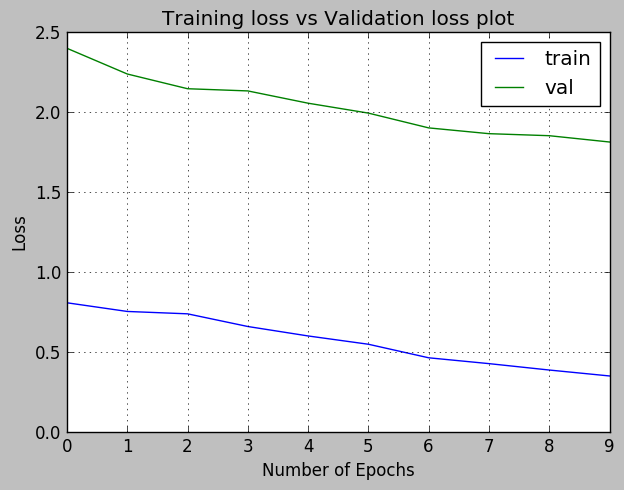

In [117]:
###plots training loss vs validation loss

xc=range(10) ## number of epochs
plt.figure(1, figsize=(7,5))
plt.plot(xc, hist.history["loss"])
plt.plot(xc, hist.history["val_loss"])

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.title("Training loss vs Validation loss plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

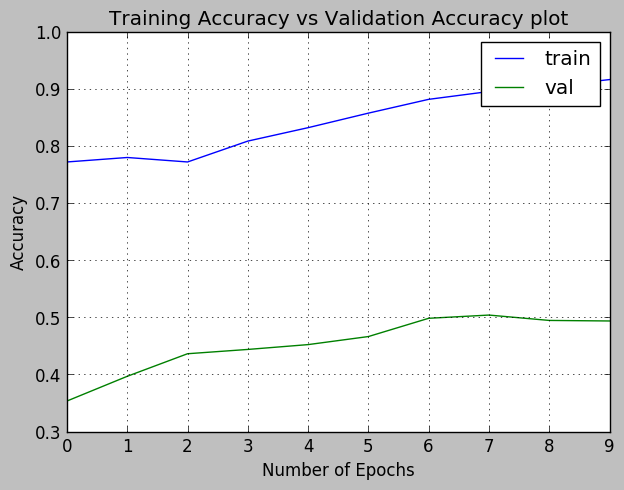

In [118]:
###plots training Accuracy vs validation Accuracy

xc=range(10) ## number of epochs
plt.figure(2, figsize=(7,5))
plt.plot(xc, hist.history["acc"])
plt.plot(xc, hist.history["val_acc"])

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.title("Training Accuracy vs Validation Accuracy plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

In [119]:
hist2=new_model.fit_generator(batches, steps_per_epoch, epochs=10, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/10
24/24 [==============================] - 1358s - loss: 0.3044 - acc: 0.9334 - val_loss: 1.8434 - val_acc: 0.4925

In [120]:
new_model.save_weights(path+'models/new_model_try_1_2.h5')

In [121]:
new_model.load_weights(path+'models/new_model_try_1_2.h5')

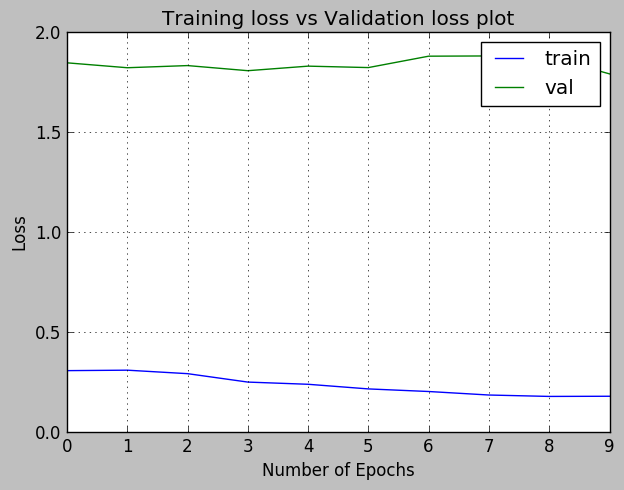

In [122]:
###plots training loss vs validation loss

xc=range(10) ## number of epochs
plt.figure(1, figsize=(7,5))
plt.plot(xc, hist2.history["loss"])
plt.plot(xc, hist2.history["val_loss"])

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.title("Training loss vs Validation loss plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

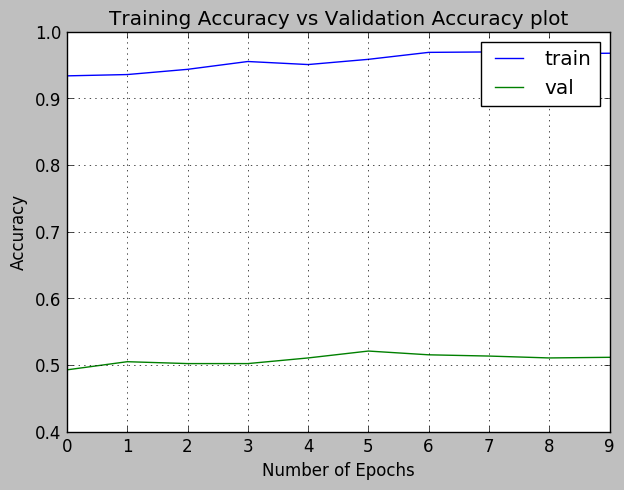

In [123]:
###plots training Accuracy vs validation Accuracy

xc=range(10) ## number of epochs
plt.figure(2, figsize=(7,5))
plt.plot(xc, hist2.history["acc"])
plt.plot(xc, hist2.history["val_acc"])

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.title("Training Accuracy vs Validation Accuracy plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

### Creating confusion matrix, to evaluate the validation results

In [124]:
from sklearn.metrics import confusion_matrix
from utils import plots, get_batches, plot_confusion_matrix, get_data

In [125]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [132]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

print('val_classes:: ' )
print( val_classes)
print('val_labels:: '  )
print( val_labels)
print (val_classes.shape)
print (val_labels.shape)

val_classes:: 
[ 0  0  0 ..., 17 17 17]
val_labels:: 
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(1064,)
(1064, 18)


In [134]:
trn_features = new_model.predict(trn, batch_size=batch_size)
val_features = new_model.predict(val, batch_size=batch_size)

In [135]:
trn_features.shape

(1533, 18)

In [136]:
val_features.shape

(1064, 18)

In [137]:
save_array(model_path+ 'train_lastlayer_features.bc', trn_features)
save_array(model_path + 'valid_lastlayer_features.bc', val_features)

In [139]:
##We can load our training and validation features later without recalculating them:
trn_features = load_array(model_path+'train_lastlayer_features.bc')
val_features = load_array(model_path+'valid_lastlayer_features.bc')

Keras' fit() function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("epoch" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting.
Tip: with our first model we should try to overfit before we start worrying about how to handle that - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).
As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
A few correct labels at random
A few incorrect labels at random
The most correct labels of each class (ie those with highest probability that are correct)
The most incorrect labels of each class (ie those with highest probability that are incorrect)
The most uncertain labels (ie those with probability closest to 0.5).
Let's see what we, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)
Calculate predictions on validation set, so we can find correct and incorrect examples:

In [142]:
# We want both the classes...
preds = new_model.predict_classes(val, batch_size=batch_size)

1064/1064 [==============================] - 347s     


In [144]:
# ...and the probabilities of belonging to a particular class of vehicle
probs = new_model.predict_proba(val, batch_size=batch_size)[:,0]

1064/1064 [==============================] - 333s     


In [153]:
print(preds.shape)
print(probs.shape)
print('\n', preds[:8])
print(probs[:8])
print(val_labels[:,1])

(1064,)
(1064,)

 [ 0  0  8 16  0 16 16 11]
[ 0.2615  0.1599  0.0422  0.047   0.9802  0.0042  0.1387  0.0035]
[ 0.  0.  0. ...,  0.  0.  0.]


In [147]:
filenames = val_batches.filenames
# Number of images to view for each visualization task
n_view = 4

In [148]:
##Helper function to plot images by index in the validation set:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

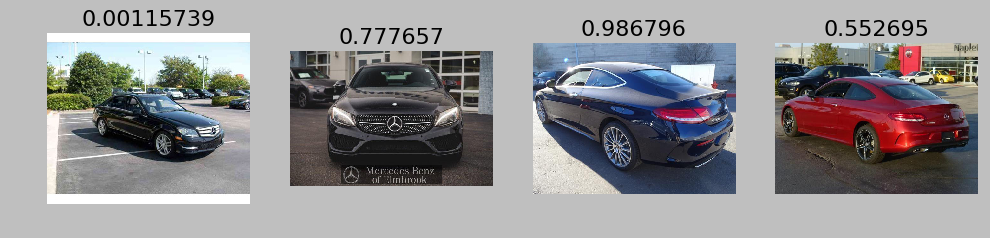

In [149]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

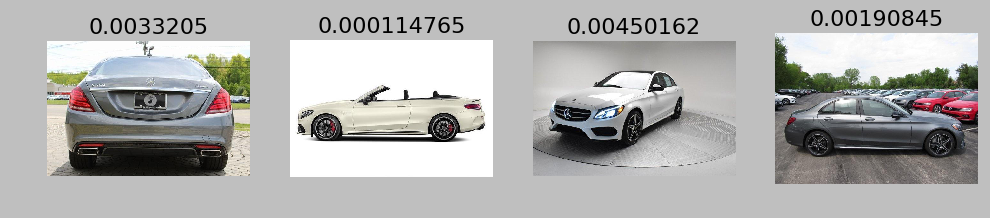

In [150]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

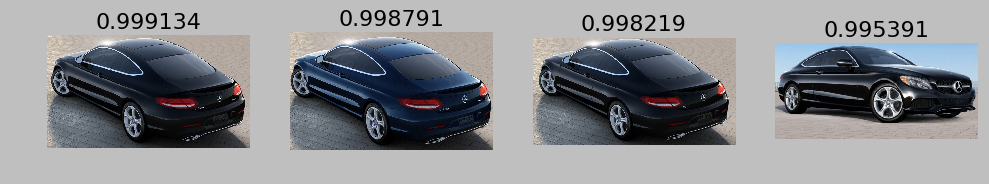

In [151]:
#3. The images we most confident were type 1, and are actually type 1
correct_type1 = np.where((preds==0) & (preds==val_labels[:,1]))[0]
most_correct_type1 = np.argsort(probs[correct_type1])[::-1][:n_view]
plots_idx(correct_type1[most_correct_type1], probs[correct_type1][most_correct_type1])

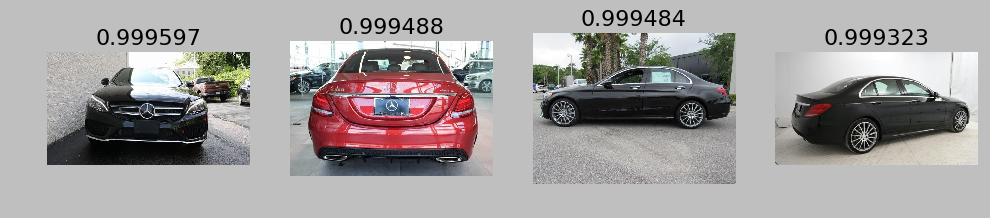

In [152]:
# as above, but type 2
correct_type2 = np.where((preds==1) & (preds==val_labels[:,1]))[0]
most_correct_type2 = np.argsort(probs[correct_type2])[:n_view]
plots_idx(correct_type2[most_correct_type2], 1-probs[correct_type2][most_correct_type2])

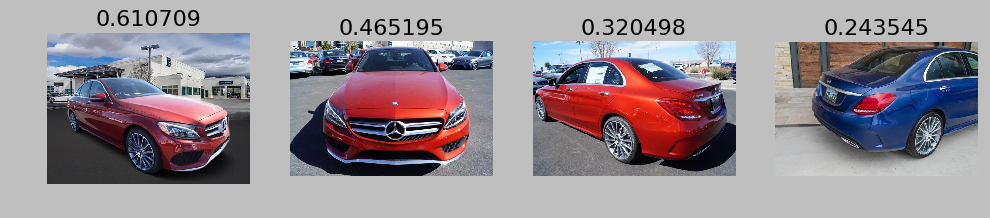

In [155]:
#3. The images we were most confident were type1, but are actually something else
incorrect_type1 = np.where((preds==0) & (preds!=val_labels[:,1]))[0]
most_incorrect_type1 = np.argsort(probs[incorrect_type1])[::-1][:n_view]
plots_idx(incorrect_type1[most_incorrect_type1], probs[incorrect_type1][most_incorrect_type1])

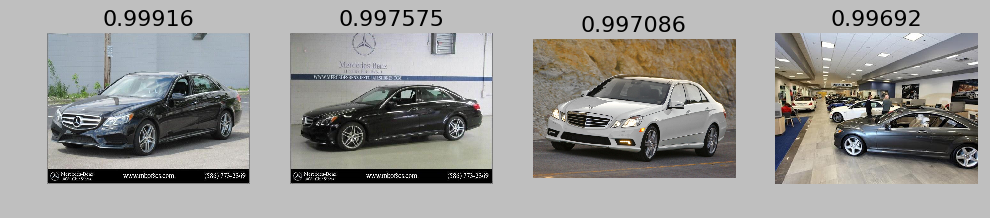

In [156]:
#3. The images we were most confident were type 2, but are actually something else
incorrect_type2 = np.where((preds==1) & (preds!=val_labels[:,1]))[0]
most_incorrect_type2 = np.argsort(probs[incorrect_type2])[:n_view]
plots_idx(incorrect_type2[most_incorrect_type2], 1-probs[incorrect_type2][most_incorrect_type2])

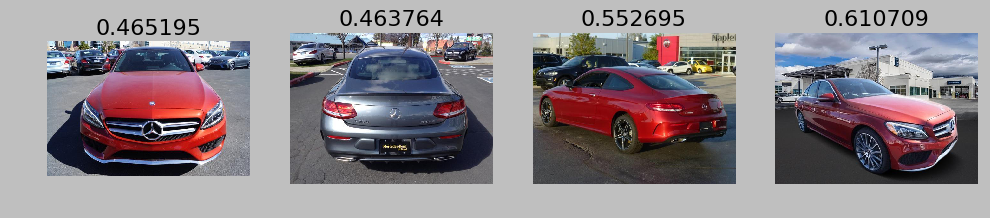

In [154]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a confusion matrix. Scikit-learn has a convenient function we can use for this purpose:

In [157]:
cm = confusion_matrix(val_classes, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[21  6  1  2  0  1  0  1 12  0  5  3  4  2  1  2  8  5]
 [ 4 40  3  0  0  3  3  6 16 15 17  1 16  2  2  3 25  1]
 [ 0  3 54  0  0  0  0  0  4  0  6  0  4  0  1  5  0 12]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  3  0  0  0  0  2  0  1]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  1  2  0  0  8  0  2  0  3  0  4  0  2  1  4  0]
 [ 0  0  0  0  0  0  0  4  2  0  2  0  0  0  0  0  0  2]
 [ 0  1  0  4  0  2  1  1 13  2  1  2  1  4  2  1  4  0]
 [ 0  5  0  0  0  0  1  2  5 26  7  1  6  1  0  1  4  1]
 [ 0  1  0  2  0  0  0  1  7 10 19  1  0  0  0  3  1  1]
 [ 0  0  0  0  0  0  1  0  2  0  3 47  0  0  0  2  1  0]
 [ 0  5  0  3  1  6  0  3  8  3  9  0 35  0  1  2  5  1]
 [ 0  2  0  0  0  0  0  2  0  2  1  0  2 25  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  1  1  2  2  0  0 73  0  0  1]
 [ 0  3  2  0  0  0  0  1  5  0 10  0  0  0  1 49  3  1]
 [ 0  3  1  0  0  0  0  4  4  2  5  2  4  1  0  2 26  3]
 [ 0  1  9  2  1  2  0  1  9  1

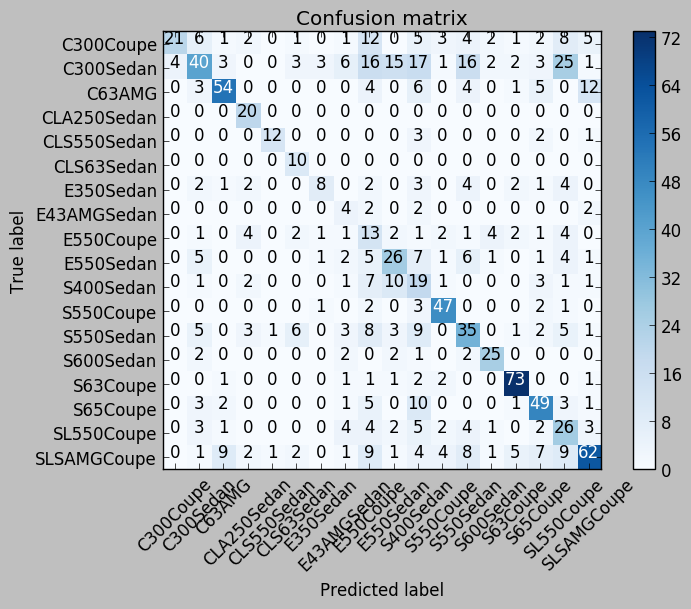

In [158]:
plot_confusion_matrix(cm, val_batches.class_indices)

### Creating heatmap

In [159]:
new_model_l = new_model.layers
new_model_conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [167]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (224,224))

In [161]:
new_model_inp = np.expand_dims(val_features[0], 0)

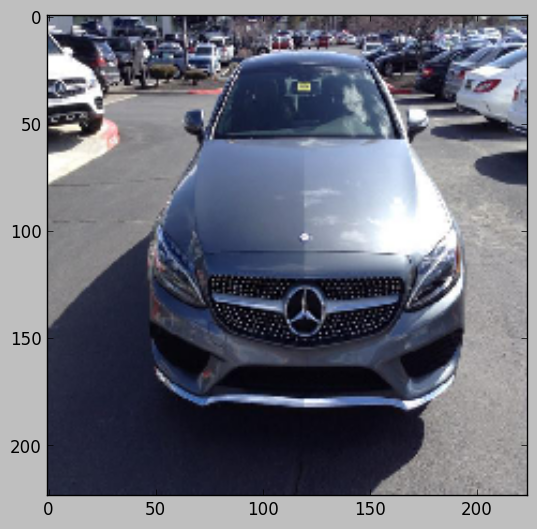

In [162]:
plt.imshow(to_plot(val[0]))

In [168]:
new_model_cm = get_cm2(new_model_inp, 0)

In [169]:
new_model_cm = get_cm2(new_model_inp, 4)

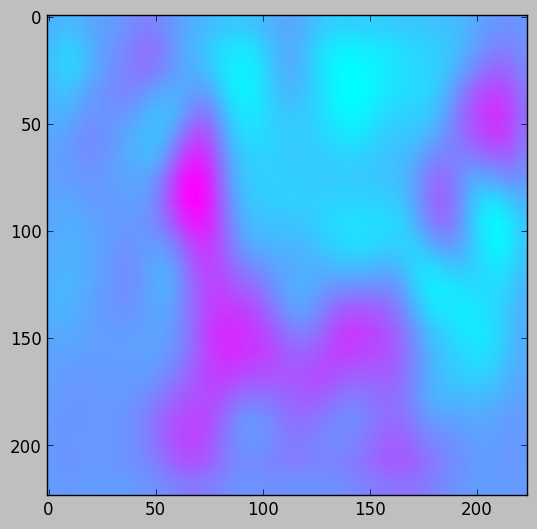

In [170]:
plt.imshow(new_model_cm, cmap="cool")

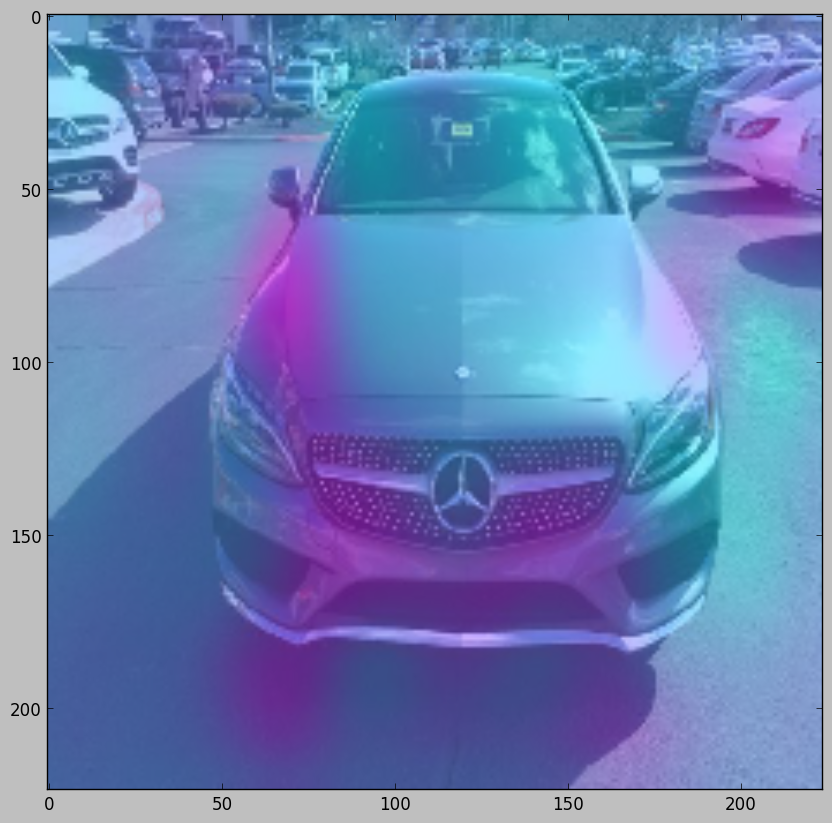

In [171]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(new_model_cm, cmap="cool", alpha=0.5)

In [172]:
new_model_inp2 = np.expand_dims(val_features[20], 0)

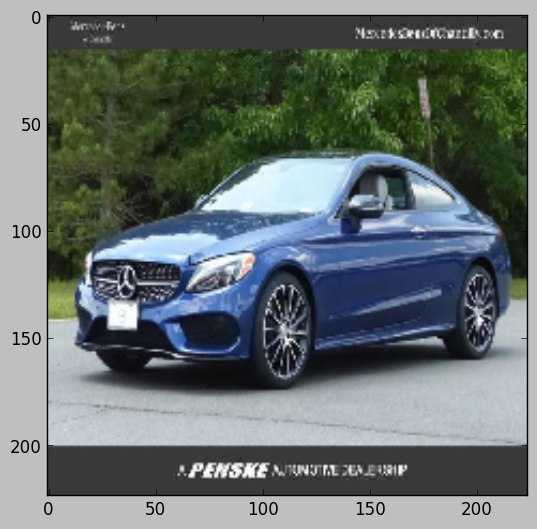

In [173]:
plt.imshow(to_plot(val[20]))

In [174]:
new_model_cm2 = get_cm2(new_model_inp2, 0)

In [175]:
new_model_cm2 = get_cm2(new_model_inp2, 4)

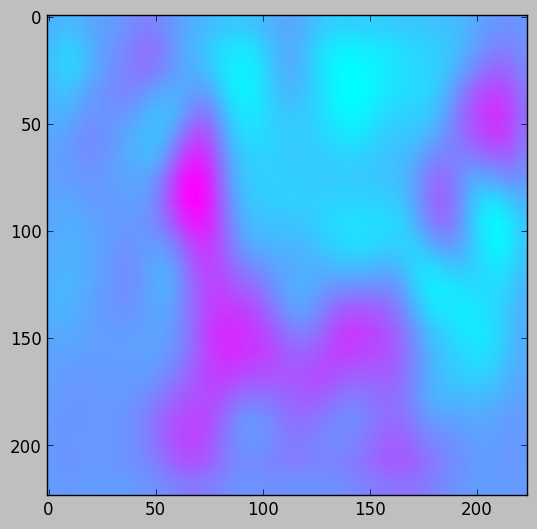

In [176]:
plt.imshow(new_model_cm2, cmap="cool")

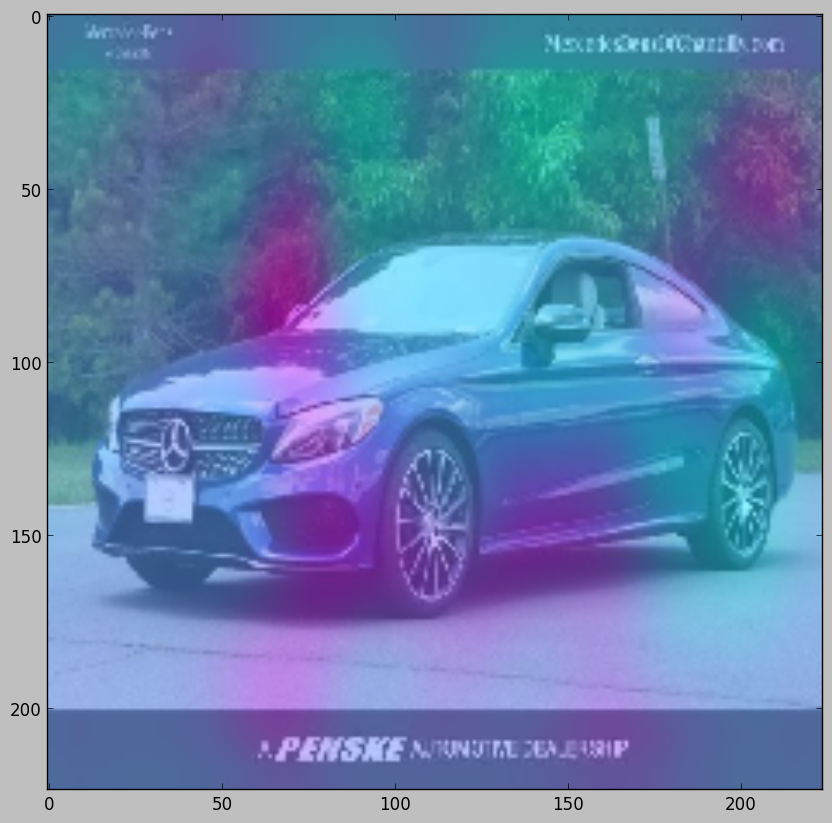

In [177]:
plt.figure(figsize=(10,10))
plot(val[20])
plt.imshow(new_model_cm2, cmap="cool", alpha=0.5)

### Trying with data augmentation

In [178]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
gen_batches = get_batches(path+'train', gen_t, batch_size=batch_size)

Found 1533 images belonging to 18 classes.


In [179]:
new_model.load_weights(path+'models/new_model_try_1_2.h5')

In [180]:
new_model.optimizer.lr=0.0005

In [ ]:
new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/3
17/24 [====================>.........] - ETA: 289s - loss: 0.1623 - acc: 0.9678 

In [79]:
new_model.optimizer.lr=0.0005

In [80]:
new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/3
24/24 [==============================] - 630s - loss: 2.4109 - acc: 0.3274 - val_loss: 2.3819 - val_acc: 0.4342

In [81]:
new_model.optimizer.lr=0.000005

In [82]:
new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/3
24/24 [==============================] - 637s - loss: 2.3005 - acc: 0.3593 - val_loss: 2.1645 - val_acc: 0.4690

In [91]:
new_model.optimizer.lr=0.0005

In [92]:
hist3 = new_model.fit_generator(batches, steps_per_epoch, epochs=15, validation_data=val_batches, 
                 validation_steps=validation_steps) ## save the run, and it returns 4 variables , which can be 
## used for visualization.

Epoch 1/15
24/24 [==============================] - 739s - loss: 3.1169 - acc: 0.2070 - val_loss: 2.5639 - val_acc: 0.4154

KeyboardInterrupt: 

In [85]:
new_model.optimizer.lr=0.0005

In [86]:
hist4 = new_model.fit_generator(batches, steps_per_epoch, epochs=3, validation_data=val_batches, 
                 validation_steps=validation_steps)

Epoch 1/3
24/24 [==============================] - 716s - loss: 3.2387 - acc: 0.2107 - val_loss: 2.2375 - val_acc: 0.4709

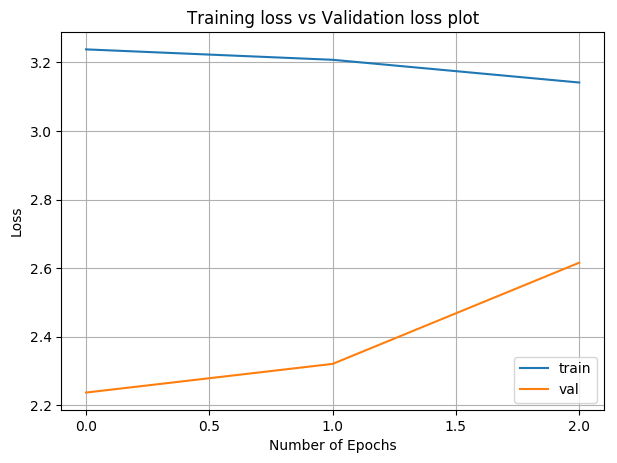

In [89]:
###plots training loss vs validation loss

xc=range(3) ## number of epochs
plt.figure(1, figsize=(7,5))
plt.plot(xc, hist.history["loss"])
plt.plot(xc, hist.history["val_loss"])

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

plt.title("Training loss vs Validation loss plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

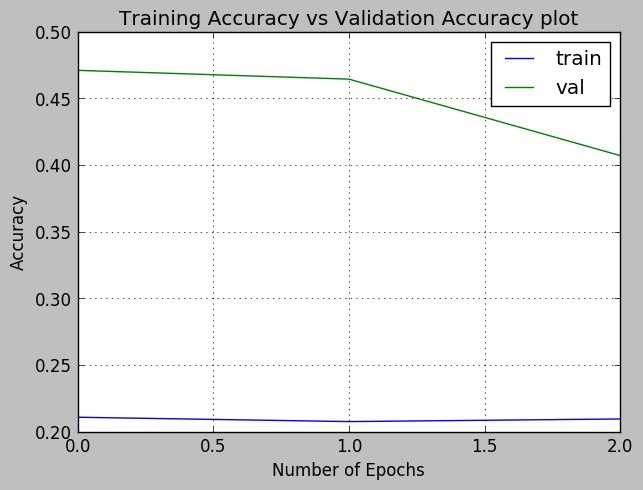

In [90]:
###plots training Accuracy vs validation Accuracy

xc=range(3) ## number of epochs
plt.figure(2, figsize=(7,5))
plt.plot(xc, hist.history["acc"])
plt.plot(xc, hist.history["val_acc"])

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.title("Training Accuracy vs Validation Accuracy plot")
plt.grid(True)
plt.legend(['train', 'val'])

plt.style.use(['classic'])

In [87]:
new_model.save_weights(path+'models/new_model_2.h5') 
## or use new_model.save(path+'models/new_model_2.hdf5) which saves model along with weights, instead of just weights
## new_model = load_mode(...)

In [88]:
new_model.load_weights(path+'models/new_model_2.h5')

In [ ]:
##score= new_model.evaluate(conv_val_feat, val_labels) ## 
## new_model.evaluate(x_test, y_test, show_accuracy=True, verbose=0)
##print('Test Loss:: ' , score[0])
##print('Test Accuracy:: ' , score[1])
##test_image = x_test[0:1]
##print(test_image.shape)
##print(model.predict(test_image))
##print(model.predict_classes(test_image))
##print(y_test[0:1])

#### Create heatmap

In [47]:
new_model_l = new_model.layers
new_model_conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [48]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [11]:
new_model_conv_val_feat = new_model.predict(val, batch_size=batch_size, verbose=1)
new_model_conv_trn_feat = new_model.predict(trn, batch_size=batch_size, verbose=1)

 624/1064 [================>.............] - ETA: 486s 

KeyboardInterrupt: 

In [126]:
save_array(path+'results/conv_val_new_model.dat', new_model_conv_val_feat)
save_array(path+'results/conv_trn_new_model.dat', new_model_conv_trn_feat)

In [127]:
new_model_conv_test_feat = new_model.predict(test, batch_size=batch_size, verbose=1)

118/118 [==============================] - 141s     


In [128]:
save_array(path+'results/conv_test_new_model_.dat', new_model_conv_test_feat)

In [12]:
new_model_conv_val_feat = load_array(path+'results/conv_val_new_model.dat')
new_model_conv_trn_feat = load_array(path+'results/conv_trn_new_model.dat')

In [13]:
new_model_conv_test_feat = load_array(path+'results/conv_test_new_model.dat')

In [49]:
new_model_inp = np.expand_dims(new_model_conv_val_feat[0], 0)

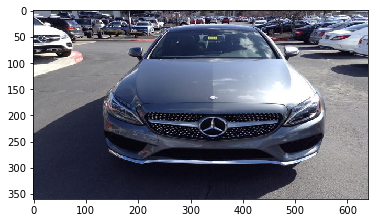

In [50]:
plt.imshow(to_plot(val[0]))

In [51]:
new_model_cm = get_cm2(inp, 0)

In [52]:
new_model_cm = get_cm2(inp, 4)

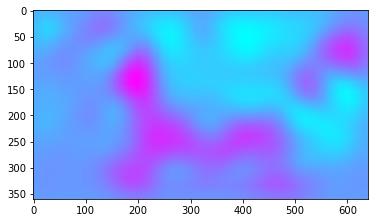

In [53]:
plt.imshow(new_model_cm, cmap="cool")

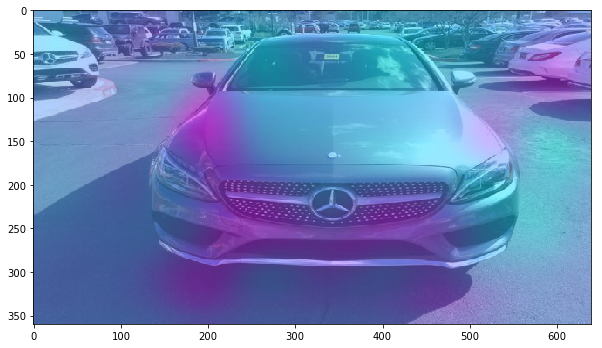

In [54]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(new_model_cm, cmap="cool", alpha=0.5)

In [ ]:
#%%

# Visualizing the intermediate layer

#
def get_featuremaps(model, layer_idx, X_batch):
	get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
	activations = get_activations([X_batch,0])
	return activations

layer_num=3
filter_num=0

activations = get_featuremaps(model, int(layer_num),test_image)

print (np.shape(activations))
feature_maps = activations[0][0]      
print (np.shape(feature_maps))

if K.image_dim_ordering()=='th':
	feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
print (feature_maps.shape)

fig=plt.figure(figsize=(16,16))
plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

num_of_featuremaps=feature_maps.shape[2]
fig=plt.figure(figsize=(16,16))	
plt.title("featuremaps-layer-{}".format(layer_num))
subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
for i in range(int(num_of_featuremaps)):
	ax = fig.add_subplot(subplot_num, subplot_num, i+1)
	#ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
	ax.imshow(feature_maps[:,:,i],cmap='gray')
	plt.xticks([])
	plt.yticks([])
	plt.tight_layout()
plt.show()
fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')

In [ ]:
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(cats)', 'class 1(Dogs)', 'class 2(Horses)','class 3(Humans)']
					
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

In [ ]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.figure()
# Plot normalized confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.figure()
plt.show()